In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import ops
from geographiclib.geodesic import Geodesic
from shapely.geometry import LineString, MultiLineString

In [2]:
# plotting modules
import matplotlib.pyplot as plt
from matplotlib import cm, colors
%matplotlib inline

## Parameters

In [3]:
# see https://www.naturalearthdata.com/downloads/
#scale = 50
scale = 10
f'1:{scale}m Physical Vectors'

'1:10m Physical Vectors'

## Download Natural Earth shapefile

In [4]:
!wget -c https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/{scale}m/physical/ne_{scale}m_coastline.zip
!mkdir -p ne_{scale}m_coastline
!unzip -od ne_{scale}m_coastline ne_{scale}m_coastline.zip

--2021-07-11 22:43:50--  https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/physical/ne_10m_coastline.zip
Resolving www.naturalearthdata.com (www.naturalearthdata.com)... 50.87.253.14
Connecting to www.naturalearthdata.com (www.naturalearthdata.com)|50.87.253.14|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip [following]
--2021-07-11 22:43:53--  https://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
Resolving naciscdn.org (naciscdn.org)... 146.201.97.163
Connecting to naciscdn.org (naciscdn.org)|146.201.97.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  ne_10m_coastline.zip
  inflating: ne_10m_coastline/ne_10m_coastline.README.html  
 extracting: ne_10m_coastline/ne_10m_coastline.VERSION.txt  
 extracting: ne_10m_coastlin

## Read dataset

In [5]:
df = gpd.read_file(f'ne_{scale}m_coastline/ne_{scale}m_coastline.shp')
df.geometry = df.geometry.apply(lambda geom: MultiLineString([geom]) if geom.geom_type == 'LineString' else geom)
df = df.explode("geometry").reset_index(drop=True)
df

,featurecla,scalerank,min_zoom,geometry
0,Coastline,0,0.0,"LINESTRING (59.91603 -67.40049, 59.67856 -67.3..."
1,Coastline,0,0.0,"LINESTRING (-51.73062 -82.06260, -52.18688 -82..."
2,Coastline,6,5.0,"LINESTRING (166.13697 -50.86435, 166.10711 -50..."
3,Coastline,0,0.0,"LINESTRING (-56.66832 -36.73642, -56.66487 -36..."
4,Coastline,0,0.0,"LINESTRING (-51.07939 3.49209, -51.09648 3.449..."
...,...,...,...,...
4128,Coastline,6,5.0,"LINESTRING (83.30511 70.80551, 83.37164 70.788..."
4129,Coastline,6,5.0,"LINESTRING (97.64568 76.75621, 97.64601 76.753..."
4130,Coastline,6,0.5,"LINESTRING (89.04713 77.14089, 89.13590 77.127..."
4131,Coastline,6,4.0,"LINESTRING (-66.77562 80.59858, -66.79027 80.5..."


<AxesSubplot:>

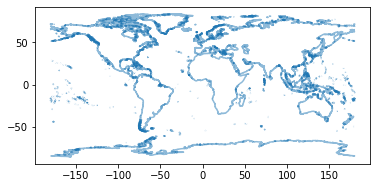

In [6]:
df.plot(alpha=0.5)

In [7]:
# helper function
def segmentize(line):
    return list(map(LineString, zip(line.coords[:-1], line.coords[1:])))

df['geom'] = df.geometry.apply(lambda geom: segmentize(geom))
df = df.explode("geom").reset_index(drop=True)
df = df.rename(columns={'geometry':'_','geom': 'geometry'}).drop(['_'], axis=1)
df

,featurecla,scalerank,min_zoom,geometry
0,Coastline,0,0.0,"LINESTRING (59.91603 -67.40049, 59.67856 -67.3..."
1,Coastline,0,0.0,"LINESTRING (59.67856 -67.39414, 59.65748 -67.3..."
2,Coastline,0,0.0,"LINESTRING (59.65748 -67.39723, 59.64625 -67.4..."
3,Coastline,0,0.0,"LINESTRING (59.64625 -67.40618, 59.64812 -67.4..."
4,Coastline,0,0.0,"LINESTRING (59.64812 -67.41595, 59.66668 -67.4..."
...,...,...,...,...
406816,Coastline,6,4.0,"LINESTRING (-66.76566 80.59947, -66.77562 80.5..."
406817,Null island,100,7.0,"LINESTRING (-0.00479 -0.00439, -0.00479 0.00482)"
406818,Null island,100,7.0,"LINESTRING (-0.00479 0.00482, 0.00433 0.00482)"
406819,Null island,100,7.0,"LINESTRING (0.00433 0.00482, 0.00433 -0.00439)"


<AxesSubplot:>

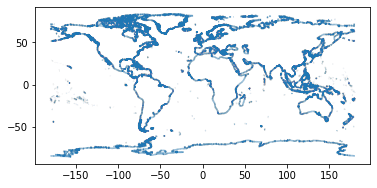

In [8]:
df.plot(alpha=0.5)

In [9]:
# for inverse geodetic calculation
geod = Geodesic.WGS84

def inverse_radian_km(geom):
    # [[lon0, lat0], [lon1, lat1]]
    coords = np.asarray(geom.coords).ravel()
    #g = geod.Inverse(float(xy0.y), float(xy0.x), float(xy1.y), float(xy1.x))
    g = geod.Inverse(coords[1], coords[0], coords[3], coords[2])
    # fix data issue
    if g['azi1'] in (0, 180):
        return (None, None)
    radian = np.pi*(90 + g['azi1'])/180
    radian = radian if radian<=np.pi else radian-2*np.pi
    return (radian, g['s12']/1000.0)

def angle_radian(geom):
    return inverse_radian_km(geom)[0]

def length_km(geom):
    return inverse_radian_km(geom)[1]

df['angle'] = df.geometry.apply(angle_radian)
df['length'] = df.geometry.apply(length_km)
# exclude bad records
df = df[~df.angle.isna()]

In [10]:
# symmetrize directions
_df = df.copy()
_df['angle'] = df.angle.apply(lambda radian: radian-np.pi if radian>=0 else np.pi+radian)
df_sym = pd.concat([df, _df])

## Rose Diagram
https://matplotlib.org/1.2.1/examples/pylab_examples/polar_bar.html

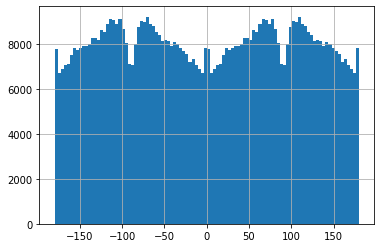

In [11]:
# make the same histogram plot as the rose diagram below
(180*df_sym['angle']/np.pi).hist(bins=100)
plt.show()

In [12]:
# Pandas 0.25.0+
angles = np.linspace(-np.pi, np.pi, 128+1, endpoint=True)
labels = (angles[1:] + angles[:-1])/2
df_sym['sector'] = labels[np.digitize(df_sym.angle, angles)-1]
df_sym_sector = df_sym.groupby(['sector']).agg(num = ('sector','count'),length = ('length','sum')).reset_index()

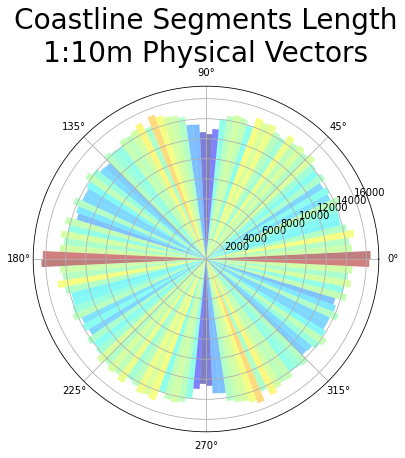

In [13]:
# force square figure and square axes looks better for polar, IMO
fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)

theta = df_sym_sector.sector.values
radii = df_sym_sector.length.values
width = np.diff(angles)[0]

bars = ax.bar(theta, radii, width=width, bottom=0.0)
for r,bar in zip(radii, bars):
    bar.set_facecolor( cm.jet((r-np.min(radii))/(np.max(radii)-np.min(radii))))
    bar.set_alpha(0.5)

plt.title(f'Coastline Segments Length\n1:{scale}m Physical Vectors', fontsize=28)
plt.savefig(f'Coastline Segments Length 1:{scale}m Physical Vectors.jpg', \
            bbox_inches='tight', dpi=150, pil_kwargs={'quality': 95})
plt.show()

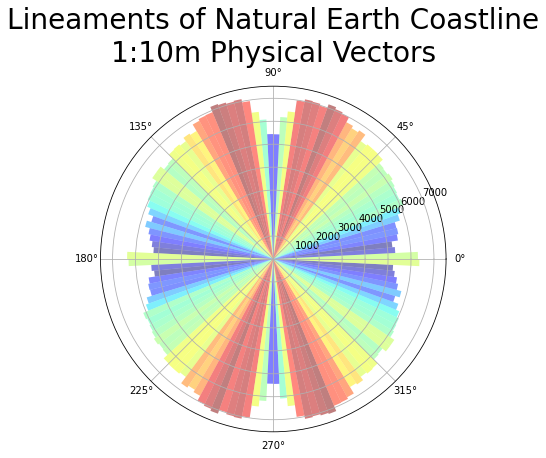

In [14]:
# force square figure and square axes looks better for polar, IMO
fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)

theta = df_sym_sector.sector.values
radii = df_sym_sector.num.values
width = np.diff(angles)[0]

bars = ax.bar(theta, radii, width=width, bottom=0.0)
for r,bar in zip(radii, bars):
    bar.set_facecolor( cm.jet((r-np.min(radii))/(np.max(radii)-np.min(radii))))
    bar.set_alpha(0.5)

plt.title(f'Lineaments of Natural Earth Coastline\n1:{scale}m Physical Vectors', fontsize=28)
plt.savefig(f'Coastline Segments Count 1:{scale}m Physical Vectors.jpg', \
            bbox_inches='tight', dpi=150, pil_kwargs={'quality': 95})
plt.show()